In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa
import country_converter as coco
from collections import Counter

cc = coco.CountryConverter()

rename_map = {
    # clean
    "nuclear": "clean",
    "uranium": "clean",
    "adv_firm_tech": "clean",

    # co2
    "co2": "co2",
    "co2 sequestered": "co2",
    "co2 stored": "co2",

    # electricity
    "electricity": "electricity",

    # electricity grid
    "AC": "electricity grid",
    "DC": "electricity grid",
    "electricity distribution grid": "electricity grid",
    "low voltage": "electricity grid",

    # EV
    "BEV charger": "EV",
    "EV battery": "EV",
    "land transport EV": "EV",

    # fossil
    "CCGT": "fossil",
    "OCGT": "fossil",
    "coal": "fossil",
    "gas": "fossil",
    "lignite": "fossil",
    "oil": "fossil",
    "oil primary": "fossil",

    # GoO
    "GoO": "GoO",
    "virtual adv_firm_tech": "GoO",
    "virtual green_ocgt": "GoO",
    "virtual offwind-ac": "GoO",
    "virtual offwind-dc": "GoO",
    "virtual offwind-float": "GoO",
    "virtual onwind": "GoO",
    "virtual solar": "GoO",
    "virtual solar rooftop": "GoO",
    "virtual solar-hsat": "GoO",
    "virtual H2 Store": "GoO",
    "virtual iron-air": "GoO",
    "virtual li-ion": "GoO",

    # renewables
    "green_ocgt": "renewables",
    "hydro": "renewables",
    "offwind-ac": "renewables",
    "offwind-dc": "renewables",
    "offwind-float": "renewables",
    "onwind": "renewables",
    "ror": "renewables",
    "solar": "renewables",
    "solar rooftop": "renewables",
    "solar-hsat": "renewables",

    # storage
    "H2": "storage",
    "H2 Electrolysis": "storage",
    "H2 Fuel Cell": "storage",
    "H2 Store": "storage",
    "H2 tank": "storage",
    "H2 turbine": "storage",
    "PHS": "storage",
    "home battery": "storage",
    "home battery charger": "storage",
    "home battery discharger": "storage",
    "iron-air": "storage",
    "iron-air charger": "storage",
    "iron-air discharger": "storage",
    "li-ion": "storage",
    "li-ion charger": "storage",
    "li-ion discharger": "storage",
}

category_colors = {
    "EV": "#baf238",              # matches BEV / EV battery theme (bright lime-green)
    "GoO": "#46caf0",             # close to ammonia/NH3 + certification-style "blue"
    "clean": "#ff8c00",           # matches nuclear/uranium (clean baseload)
    "co2": "#f29dae",             # matches co2 family (soft pink)
    "electricity grid": "#97ad8c",# matches distribution grid / low voltage
    "fossil": "#545454",          # coal baseline grey (neutral fossil indicator)
    "renewables": "#235ebc",      # wind blue (iconic renewable color)
    "storage": "#ace37f"          # battery green (unifying storage theme)
}

grouping_storage = {
    "H2": "H2",
    "H2 Electrolysis": "H2",
    "H2 Fuel Cell": "H2",
    "H2 Store": "H2",
    "H2 tank": "H2",
    "H2 turbine": "H2",
    "home battery": "home battery",
    "home battery charger": "home battery",
    "home battery discharger": "home battery",
    "iron-air": "iron-air",
    "iron-air charger": "iron-air",
    "iron-air discharger": "iron-air",
    "li-ion": "li-ion",
    "li-ion charger": "li-ion",
    "li-ion discharger": "li-ion",
    "BEV charger": "EV",
    "EV battery": "EV",
    "land transport EV": "EV",
}

def prepare_network(n, year):

    # Fill missing colors
    append_color = {
        '':'#aaaaaa', 
        'none':'#aaaaaa',
        'H2 tank':'#bf13a0', 
        'H2 tank Electrolysis':'#bf13a0',
        'H2 tank Fuel Cell':'#bf13a0',
        'adv_firm_tech':'#d19D00', 
        'green_ocgt':'#2fb537', 
        'virtual adv_firm_tech':'#d19D00',
        'virtual green_ocgt':'#2fb537', 
        'iron-air':"grey",
        'iron-air charger':"grey",
        'iron-air discharger':"grey",
        'virtual iron-air':"grey",
    }

    for key, value in append_color.items():
        n.carriers.loc[key,"color"] = value

    # Change snapshotdate to year
    for c in n.components:
        for table in c.dynamic:
            c.dynamic[table].index = c.dynamic[table].index.map(lambda x: x.replace(year=year))
    
    n.snapshots = n.snapshots.map(lambda x: x.replace(year=year))

    return n
    

def strip_network_GoO(n):
    m = n.copy()
    
    nodes_to_keep = m.buses[m.buses.carrier == "GoO"].index
    m.remove("Bus", m.buses.index.symmetric_difference(nodes_to_keep))
    
    carrier_to_keep = list(m.carriers.filter(like="virtual", axis=0).index)
    carrier_to_keep.append("GoO")
    
    for c in n.components:
        if c.name not in ["Generator", "Link", "Line", "Store", "StorageUnit", "Load"]:
            continue
        
        if c.name in ["Link", "Line"]:
            location_boolean = c.static.bus0.isin(nodes_to_keep) & c.static.bus1.isin(
                nodes_to_keep
            )
        else:
            location_boolean = c.static.bus.isin(nodes_to_keep)
        to_keep = c.static.index[location_boolean & c.static.carrier.isin(carrier_to_keep)]
        to_drop = c.static.index.symmetric_difference(to_keep)
        m.remove(c.name, to_drop)

    return m


def get_stats_all(df_all, stats, **kwarg):
    cols = {}
    
    for year, sc in df_all.index:
        n = df_all.loc[(year, sc)]
        # Use tuple (year, scenario) as column key instead of network name
        cols[(year, sc)] = getattr(n.statistics, stats)(nice_names=False, **kwarg)

    df = pd.DataFrame(cols).fillna(0)
    # Create MultiIndex columns with year and scenario
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=['year', 'scenario'])
    colors = [n.carriers.loc[i,"color"] for i in df.index.get_level_values("carrier")]
    
    return df, colors


def sum_except_color(group):
    sum_values = group.drop(columns='color').sum()
    color = group['color'].iloc[0]
    sum_values['color'] = color
    
    return sum_values


def plot_bar(df, colors, ylabel=None, title=None, figsize=(12, 6), vert_lines=True):
    # Create figure and axis with adjustable size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Remove column names from MultiIndex if present
    df_plot = df.copy()
    if isinstance(df_plot.columns, pd.MultiIndex):
        df_plot.columns = df_plot.columns.set_names([None, None])

    # Create stacked bar plot on the provided axis
    df_plot.T.plot(kind="bar", stacked=True, legend=True, color=colors, ax=ax)

    # Reverse legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],
              loc='upper left', bbox_to_anchor=(1, 1),
              title='Carrier')

    # Add total values above each bar
    bar_totals = df.T.sum(axis=1)  # totals per bar
    bar_height = df.clip(lower=0).T.sum(axis=1)
    
    for i, total in enumerate(bar_totals):
        ax.text(
            i,                              # x position
            bar_height.iloc[i],             # y position
            "{:.0f}".format(total),         # label
            ha='center', va='bottom',
            fontsize=9
        )

    # Check if we have MultiIndex columns (year, scenario structure)
    if isinstance(df.columns, pd.MultiIndex):
        # Get years and scenarios
        years = df.columns.get_level_values('year').unique()
        scenarios = df.columns.get_level_values('scenario').unique()
        
        # Set x-axis labels to show only scenarios
        ax.set_xticklabels([sc for _, sc in df.columns], rotation=45, ha='right')
        
        # Add year labels as a secondary x-axis
        # Calculate position for each year group
        year_positions = []
        year_labels = []
        for year in years:
            year_cols = [i for i, (y, s) in enumerate(df.columns) if y == year]
            if year_cols:
                year_positions.append(np.mean(year_cols))
                year_labels.append(str(year))
        
        # Add vertical lines between years
        if vert_lines and len(years) > 1:
            for year in years[:-1]:
                year_cols = [i for i, (y, s) in enumerate(df.columns) if y == year]
                if year_cols:
                    ax.axvline(max(year_cols) + 0.5, color='gray', linestyle='--', linewidth=1)
        
        # Add secondary x-axis for years
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(year_positions)
        ax2.set_xticklabels(year_labels)
        ax2.tick_params(axis='x', which='both', length=0)  # Hide tick marks
        ax2.spines['top'].set_visible(False)
    else:
        # Fallback for non-MultiIndex columns (old behavior)
        ax.set_xticklabels(df.columns, rotation=45, ha='right')
        
        if vert_lines:
            group_bars = max(Counter([int(c[-4:]) for c in df.columns]).values())
            num_bars = df.T.shape[0]
            for i in range(0, num_bars, group_bars):
                ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=1)
    
    # Labels
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    ax.grid(axis='y')

    return ax


def group_by_build_year(n, c):
    """Group components by their build year."""
    if "build_year" in n.c[c].static.columns:
        return n.c[c].static['build_year']
    else:
        return None 

def group_by_country_focus(n, c, port=""):
    """Group components by specific country and find alternative if missing."""
    from pypsa.statistics import groupers
    
    bus = f"bus{port}"
    component_buses = n.c[c].static[bus]
    buses_country = n.c.buses.static.country
    
    country = groupers._map_with_multiindex(component_buses, buses_country)
    
    if "bus1" in df.columns:
        missing = country.isna() | (country == "")

        component_bus1 = n.c[c].static["bus1"]
        country[missing] = groupers._map_with_multiindex(component_bus1, buses_country)[missing]

    return country.rename("country1")

pypsa.statistics.groupers.add_grouper("build_year", group_by_build_year)
pypsa.statistics.groupers.add_grouper("country1", group_by_country_focus)

# TODOs: find the solar potential and the percentage of it actually being used. Did we max it out?
# TODOs: what are the renewable potential, and what is remaining


# 1. Retrieve all models

In [18]:
years = [2025, 2030, 2035, 2040]
scenarios = ["baseline",
             "energy-match-50",
             #"hourly-match-50-90",
             #"hourly-match-50-95",
             #"hourly-match-50-98",
             #"hourly-match-50-99",
             ]

# Build MultiIndex
index = pd.MultiIndex.from_product(
    [years, scenarios],
    names=["year", "scenario"]
)

# Create empty DataFrame
df_networks = pd.DataFrame(index=index, columns=["network"])

# Fill it
for year, sc in index:
    try:
        n = pypsa.Network(f"../results/{sc}/networks/base_s_39___{year}.nc")
    except:
        print(f"{sc}-{year} not availabe")
        continue
    n = prepare_network(n, year)
    n.name = f"{sc}-{year}"
    df_networks.loc[(year, sc), "network"] = n

    m = strip_network_GoO(n)
    m.name = "GoO-" + m.name
    df_networks.loc[(year, sc), "GoO"] = m

df_networks = df_networks.dropna()

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current:

# 3-5) GO market Scenario impacts (single year, system/single country)

### (a) Energy mixes

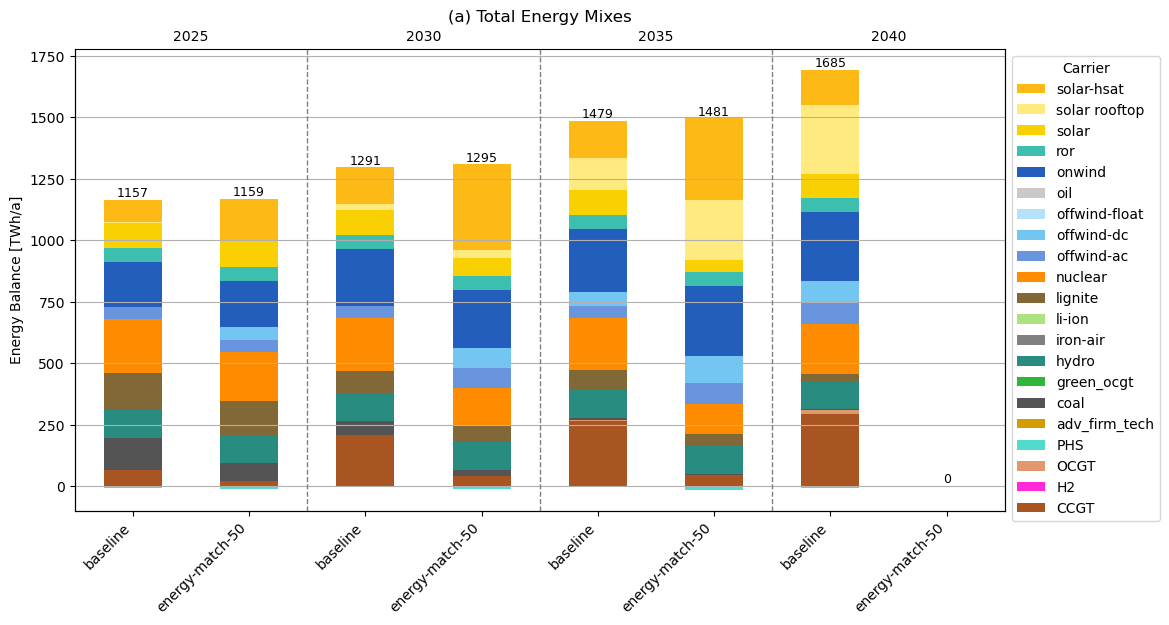

In [19]:
df, colors = get_stats_all(df_networks["network"], "energy_balance", groupby=["carrier","bus_carrier"])
df["color"] = colors

df = df[
    df.index.get_level_values("bus_carrier").isin(["AC",
                                                   "low voltage",
                                                   ])
    & ~df.index.get_level_values("carrier").isin(["AC",
                                                  "DC",
                                                  "electricity",
                                                  "low voltage",
                                                  "electricity distribution grid",
                                                  "BEV charger",
                                                  "home battery charger",
                                                  "home battery discharger",
                                                  ])
]

df = df.groupby("carrier").apply(sum_except_color)
df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e6

ax = plot_bar(df, colors, ylabel="Energy Balance [TWh/a]", title="(a) Total Energy Mixes")

### (b) Energy mixes (direct from the GO market)

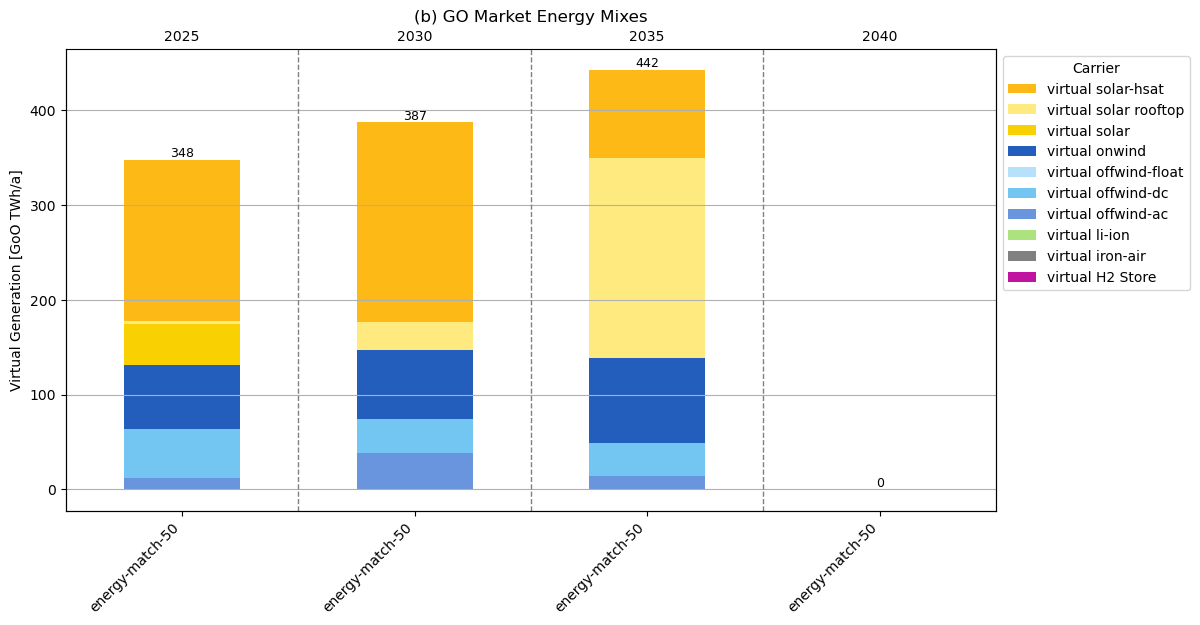

In [ ]:
df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
df, colors = get_stats_all(df_GoO["GoO"], "energy_balance")
df["color"] = colors
df = df[df.index.get_level_values("carrier") != "GoO"].groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e6

ax = plot_bar(df, colors, ylabel="Virtual Generation [GoO TWh/a]", title="(b) GO Market Energy Mixes")

### (c) Capacity mixes

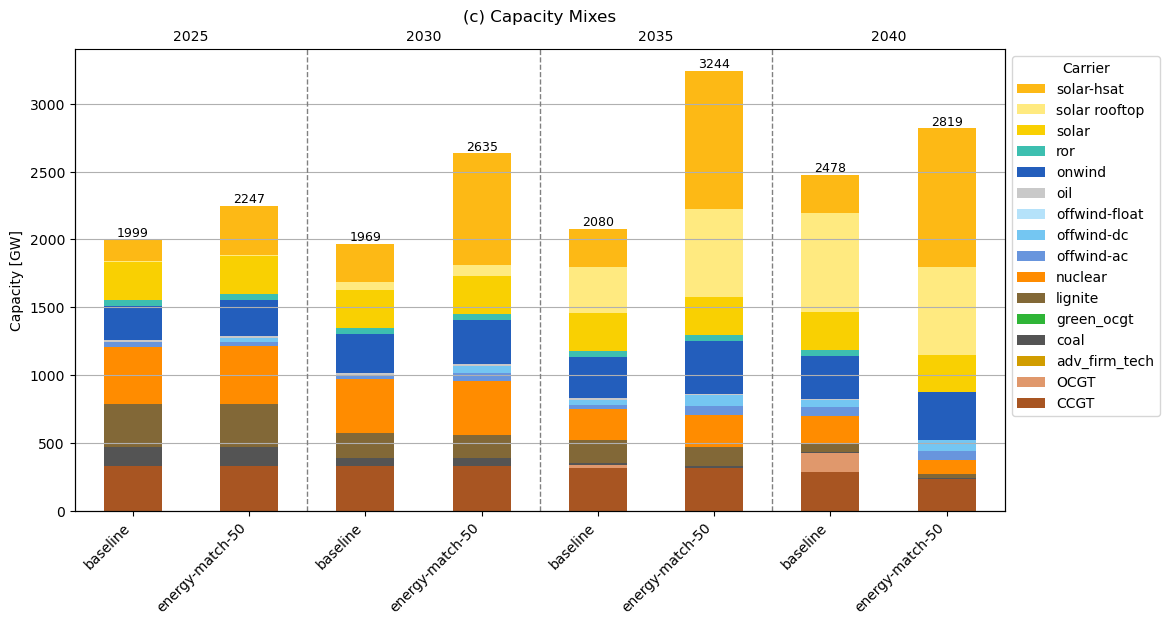

In [22]:
df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier","bus_carrier"])
df["color"] = colors

df = df[
    ~df.index.get_level_values("bus_carrier").isin(["GoO","co2","co2 stored"])
    & ~df.index.get_level_values("carrier").isin(["AC","DC","electricity distribution grid","low voltage"] + list(grouping_storage.keys()))
    & ~df.index.get_level_values("component").isin(["Store","StorageUnit"])
]

df = df.loc[~df.index.isin([("Generator","coal","coal"),("Generator","gas","gas")])]
df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e3

ax = plot_bar(df, colors, ylabel="Capacity [GW]", title="(c) Capacity Mixes")

### (d) Capacity mixes of new technologies

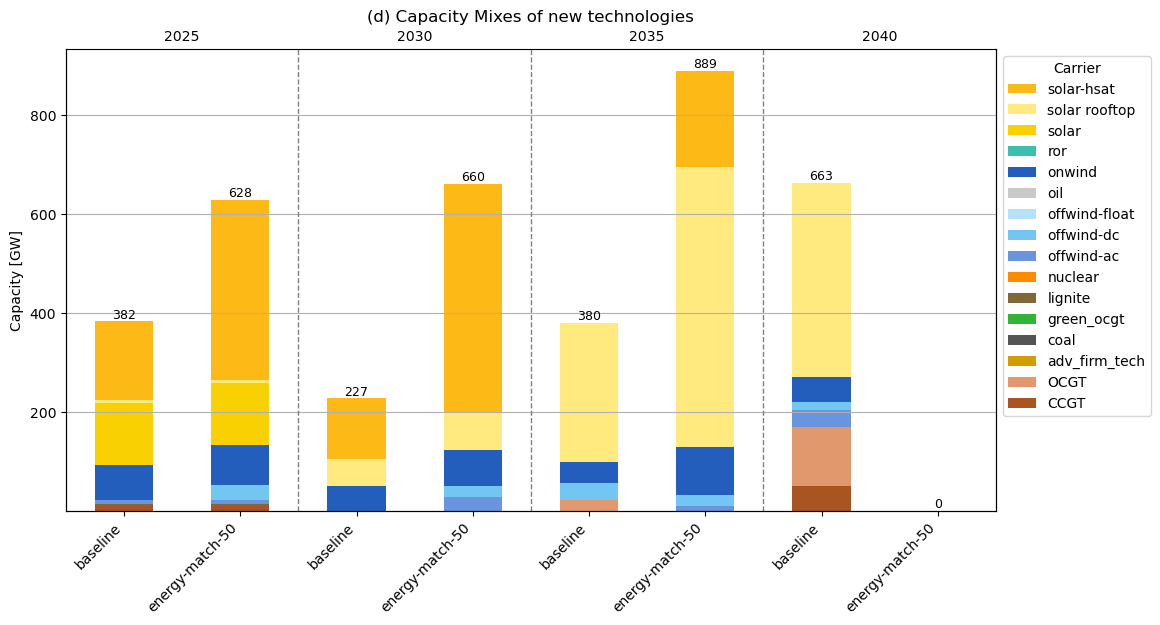

In [23]:
df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier","bus_carrier","build_year"])

for c in df.columns:
    scenario_year = int(c[0])
    df.loc[df.index.get_level_values("build_year") != scenario_year,c] = 0

df["color"] = colors

df = df[
    ~df.index.get_level_values("bus_carrier").isin(["GoO","co2","co2 stored"])
    & ~df.index.get_level_values("carrier").isin(["AC","DC","electricity distribution grid","low voltage"] + list(grouping_storage.keys()))
    & ~df.index.get_level_values("component").isin(["Store","StorageUnit"])
]

df = df.loc[~df.index.isin([("Generator","coal","coal"),("Generator","gas","gas")])]
df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e3

ax = plot_bar(df, colors, ylabel="Capacity [GW]", title="(d) Capacity Mixes of new technologies")

### (e) Participating storage capacity (Stores)

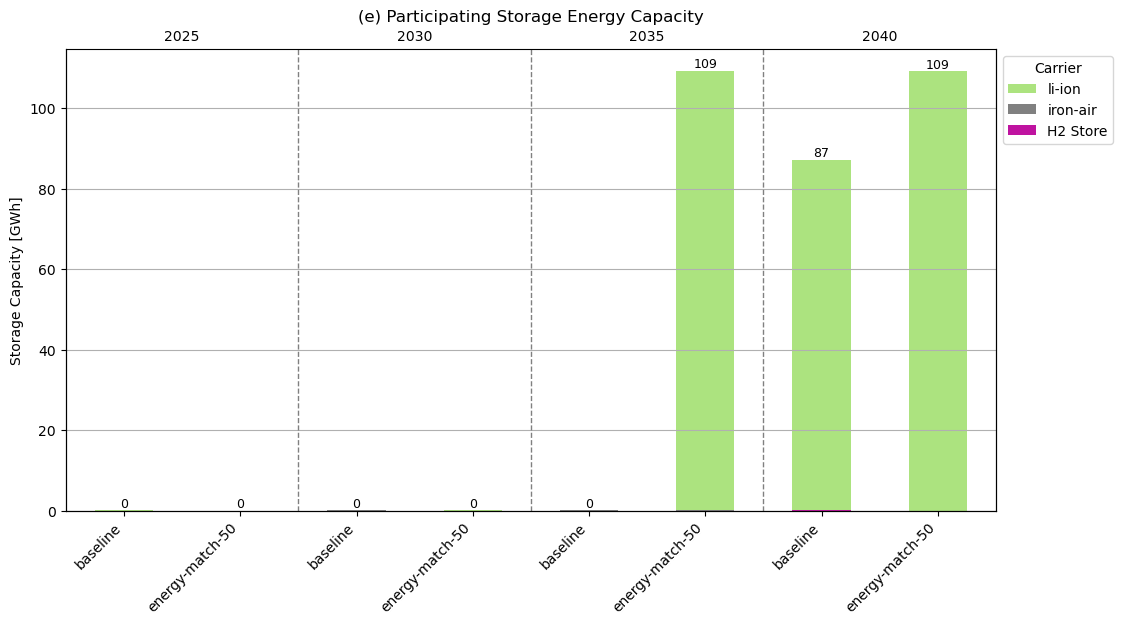

In [24]:
df, colors = get_stats_all(df_networks["network"], "optimal_capacity")
df["color"] = colors

df = df[
    df.index.get_level_values("component").isin(["Store"])
    & df.index.get_level_values("carrier").isin(list(grouping_storage.keys()))
    & ~df.index.get_level_values("carrier").isin(['EV battery','home battery'])
]

df = df.groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e3

ax = plot_bar(df, colors, ylabel="Storage Capacity [GWh]", title="(e) Participating Storage Energy Capacity")

### (e) Participating storage capacity (Links)

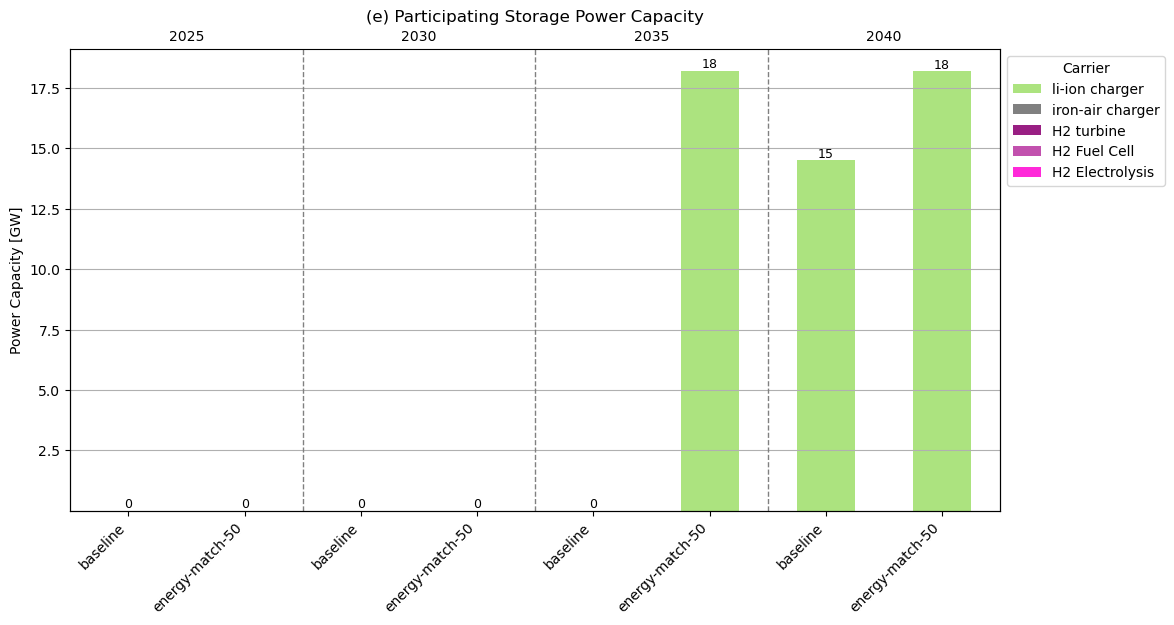

In [25]:
df, colors = get_stats_all(df_networks["network"], "optimal_capacity")
df["color"] = colors

df = df[
    df.index.get_level_values("component").isin(["Link"])
    & df.index.get_level_values("carrier").isin(list(grouping_storage.keys()))
    & ~df.index.get_level_values("carrier").isin(['BEV charger','li-ion discharger','iron-air discharger','home battery charger','home battery discharger'])
]

df = df.groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e3

ax = plot_bar(df, colors, ylabel="Power Capacity [GW]", title="(e) Participating Storage Power Capacity")

### (f) Total system cost

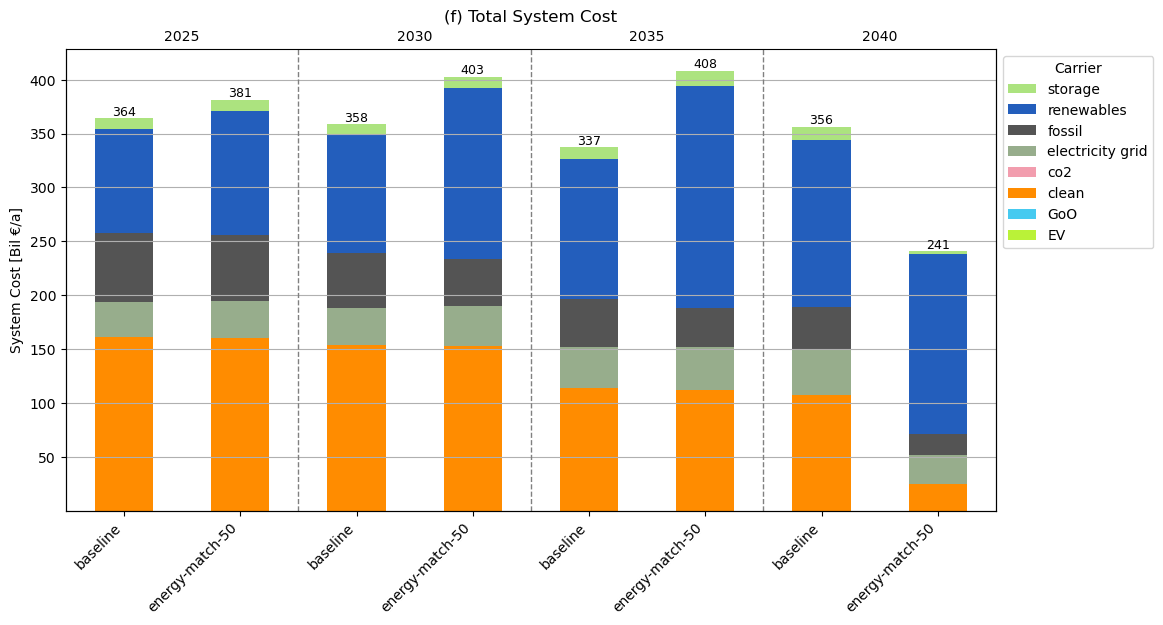

In [26]:
df, _ = get_stats_all(df_networks["network"], "system_cost")
df = df.rename(index=rename_map).groupby("carrier").sum()
df = df / 1e9 # to Billion

colors = [category_colors[i] for i in df.index]

ax = plot_bar(df, colors, ylabel="System Cost [Bil €/a]", title="(f) Total System Cost")

### (g) Total system cost of new technologies

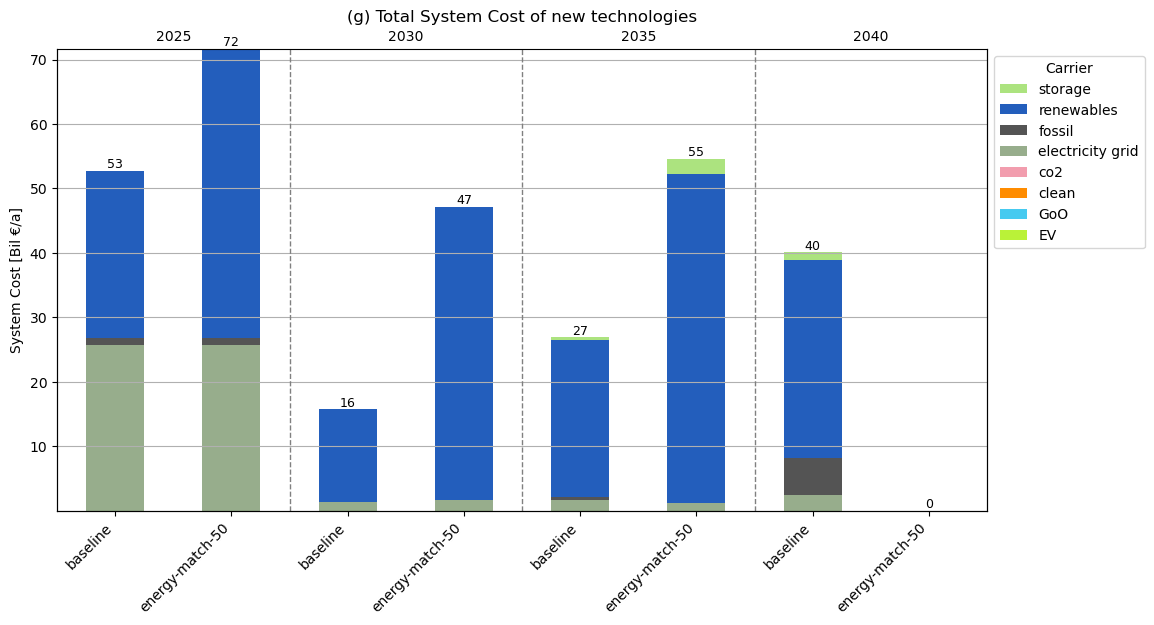

In [ ]:
df, _ = get_stats_all(df_networks["network"], "system_cost", groupby=["carrier","build_year"])

for c in df.columns:
    scenario_year = int(c[0])
    df.loc[df.index.get_level_values("build_year") != scenario_year,c] = 0

df = df.rename(index=rename_map).groupby("carrier").sum()
df = df / 1e9 # to Billion

colors = [category_colors[i] for i in df.index]

ax = plot_bar(df, colors, ylabel="System Cost [Bil €/a]", title="(g) Total System Cost of new technologies")

### (h) Total GO market revenue (disaggregated by technologies)

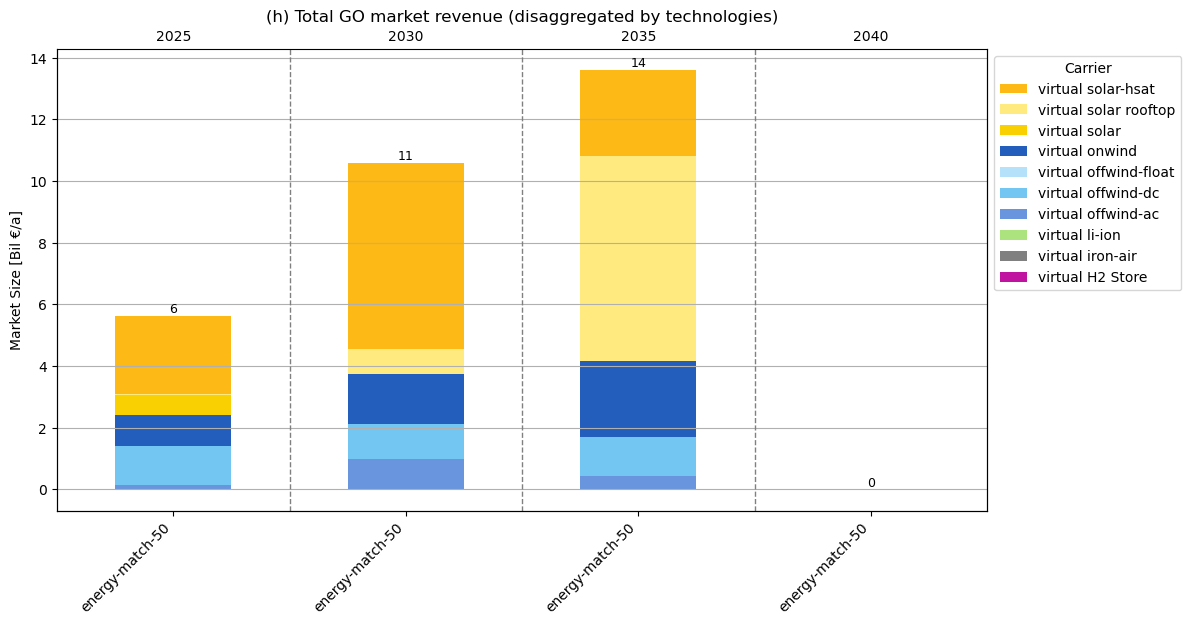

In [28]:
df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
df, colors = get_stats_all(df_GoO["GoO"], "revenue", groupby=["carrier"])
df["color"] = colors
df = df[df.index.get_level_values("carrier") != "GoO"].groupby("carrier").apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e9 # to Billion

ax = plot_bar(df, colors, ylabel="Market Size [Bil €/a]", title="(h) Total GO market revenue (disaggregated by technologies)")

# 4) How the GO Markets impacts different countries

## All countries

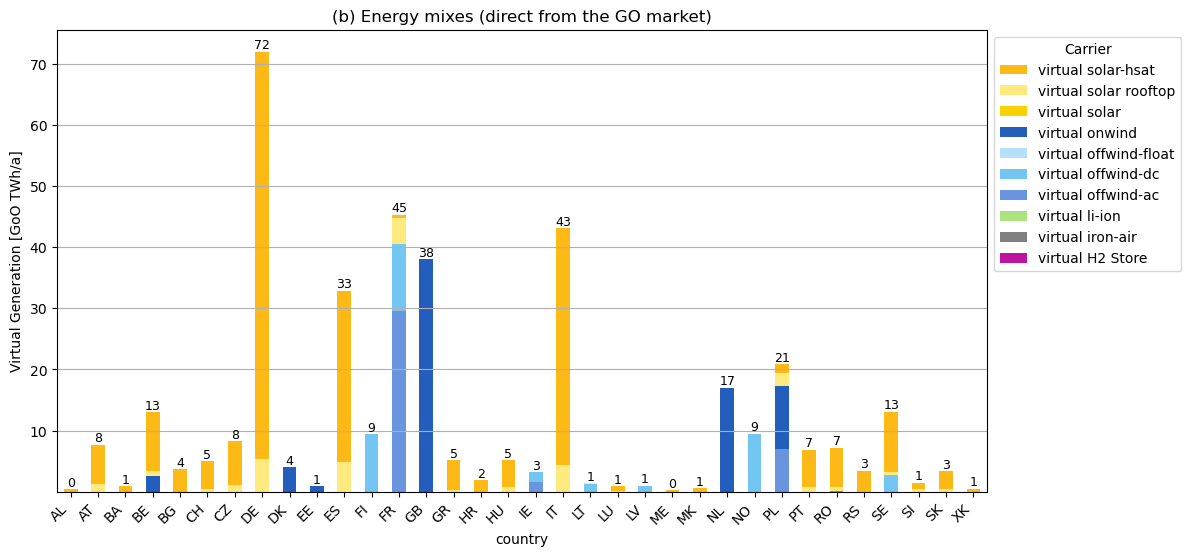

In [29]:
year = 2030
scen = "energy-match-50"

df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
df, colors = get_stats_all(df_GoO["GoO"], "energy_balance", groupby=["country","carrier"])
df["color"] = colors
df = df[df.index.get_level_values("carrier") != "GoO"]#.groupby("carrier").apply(sum_except_color)

colors = df.groupby("carrier").apply(sum_except_color)["color"]
df_country = df[year,scen]
df_country = df_country.unstack("country").groupby("carrier").sum()
df_country = df_country / 1e6

ax = plot_bar(
    df_country, 
    colors, 
    ylabel="Virtual Generation [GoO TWh/a]", 
    title="(b) Energy mixes (direct from the GO market)",
    vert_lines=False
)

## Single countries

In [45]:
import country_converter

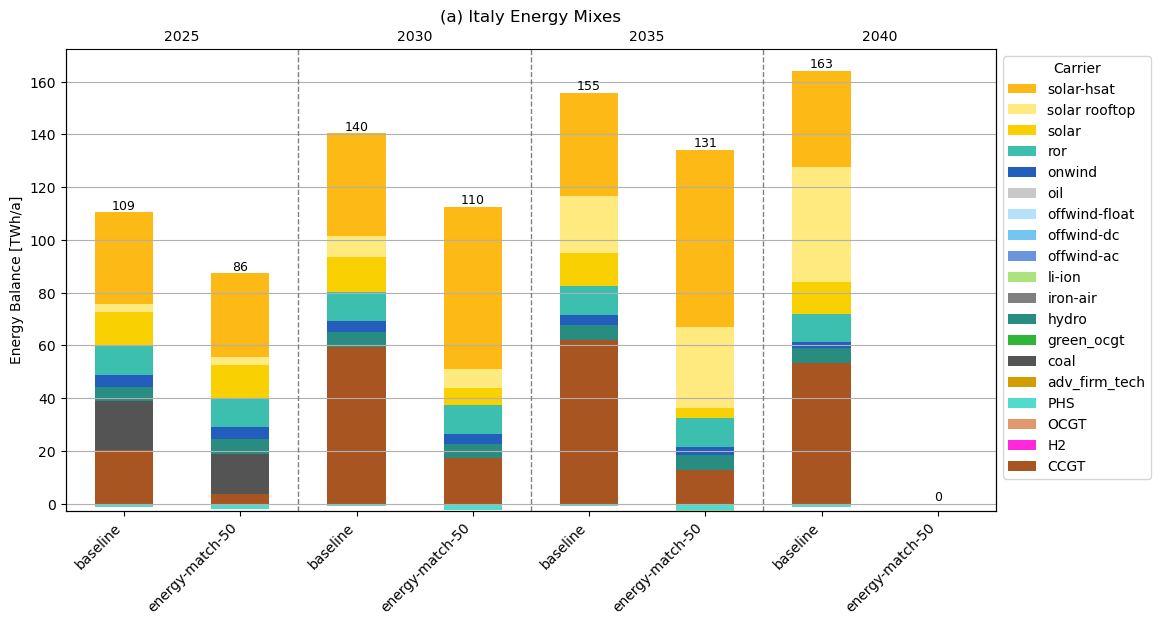

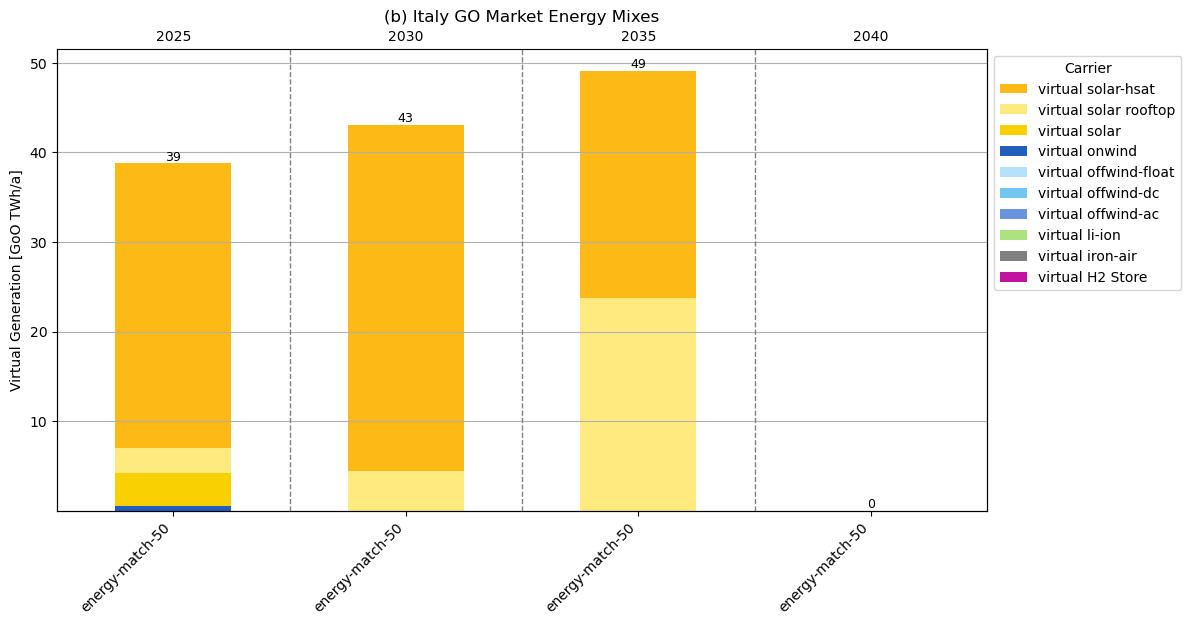

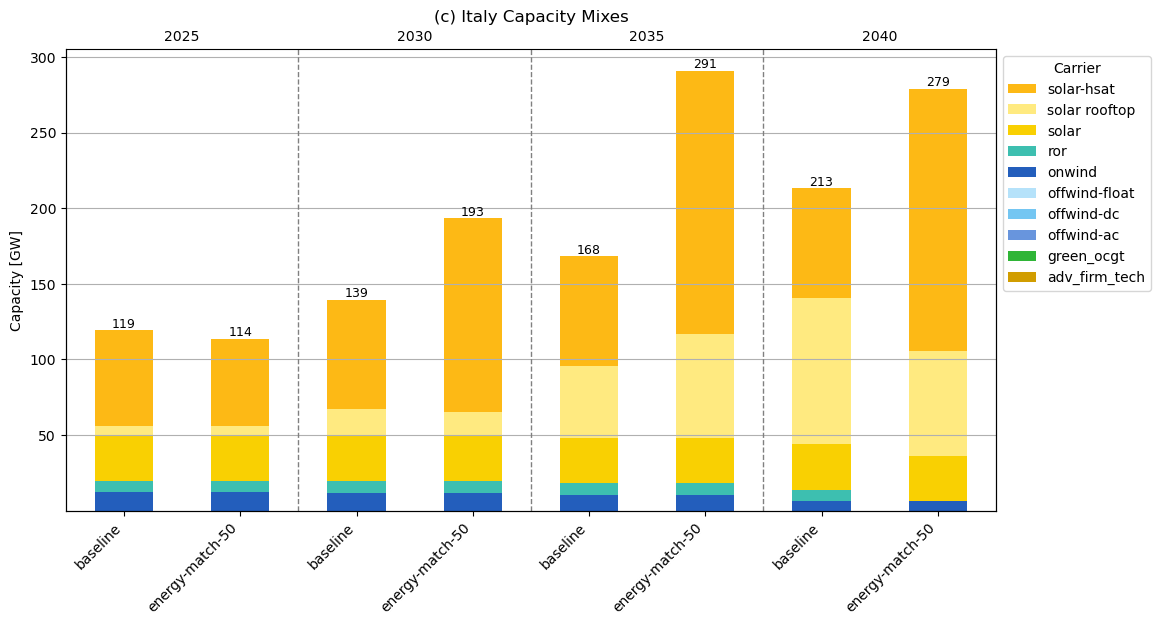

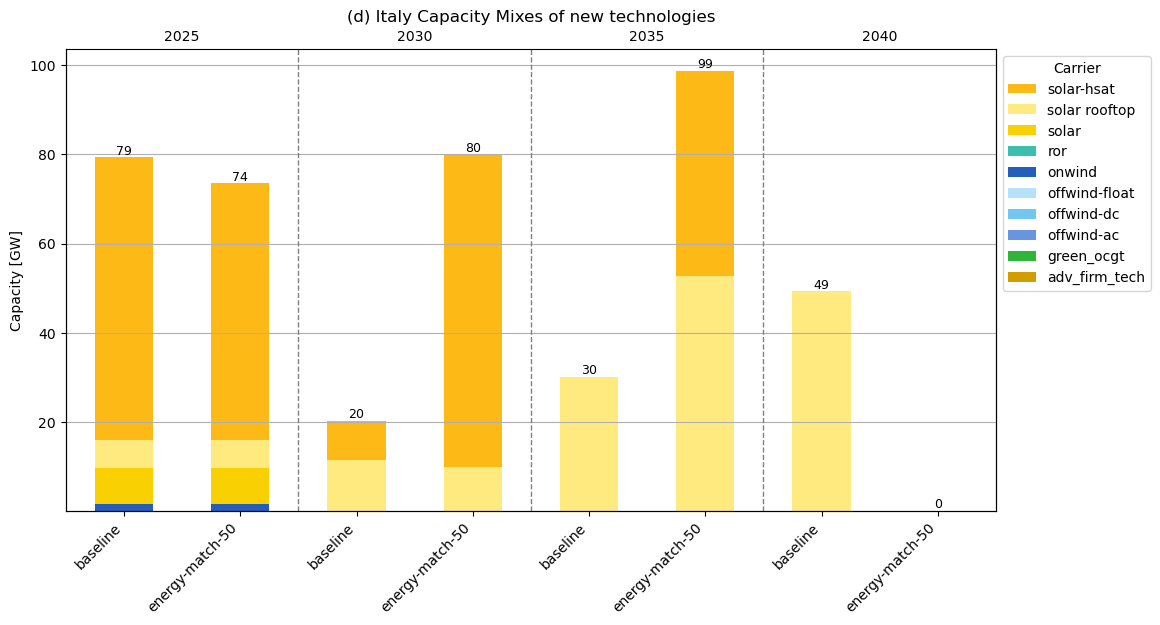

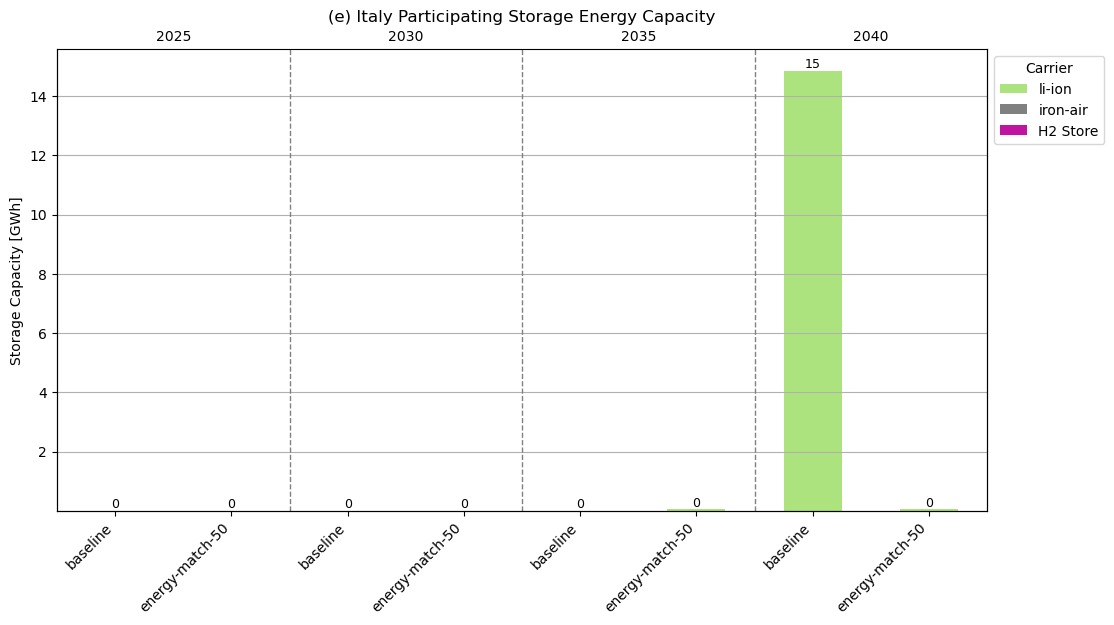

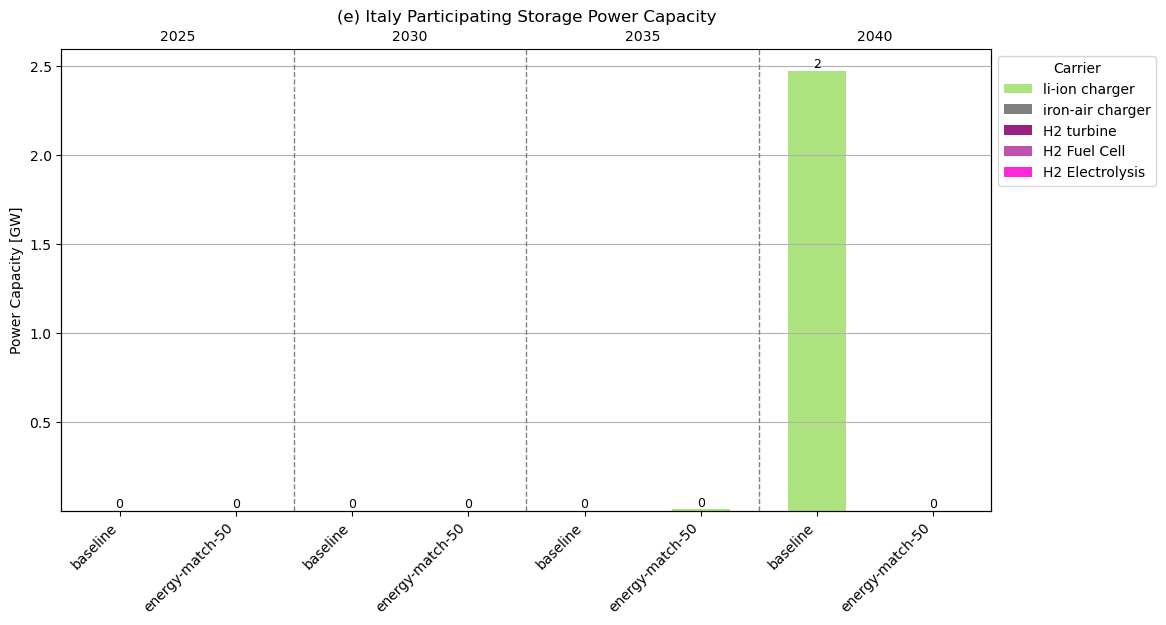

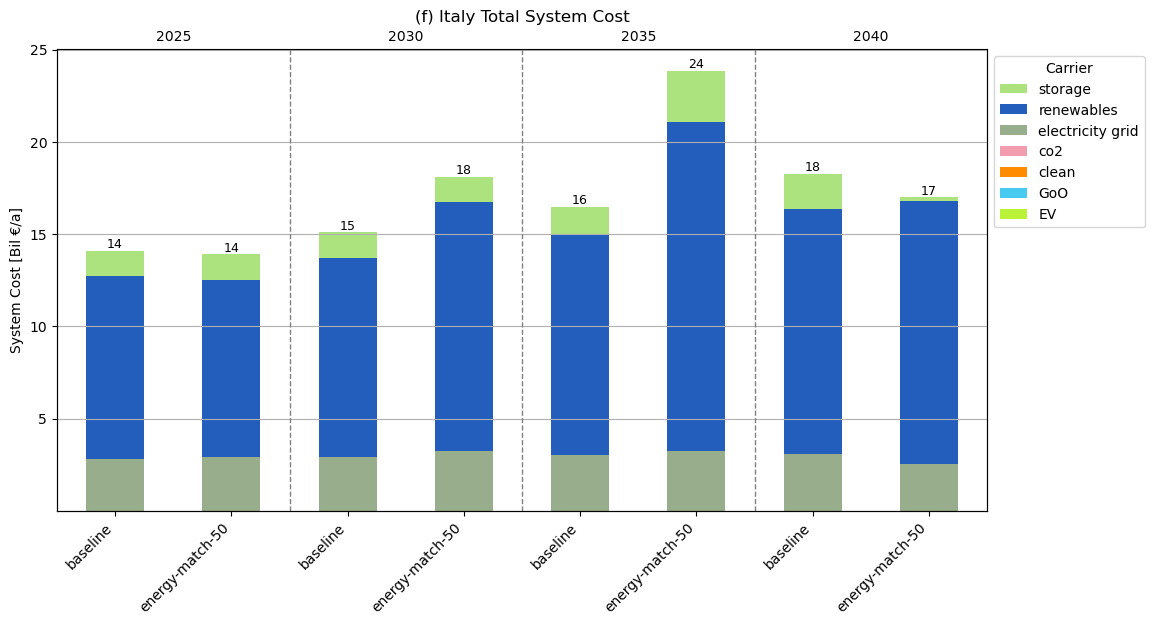

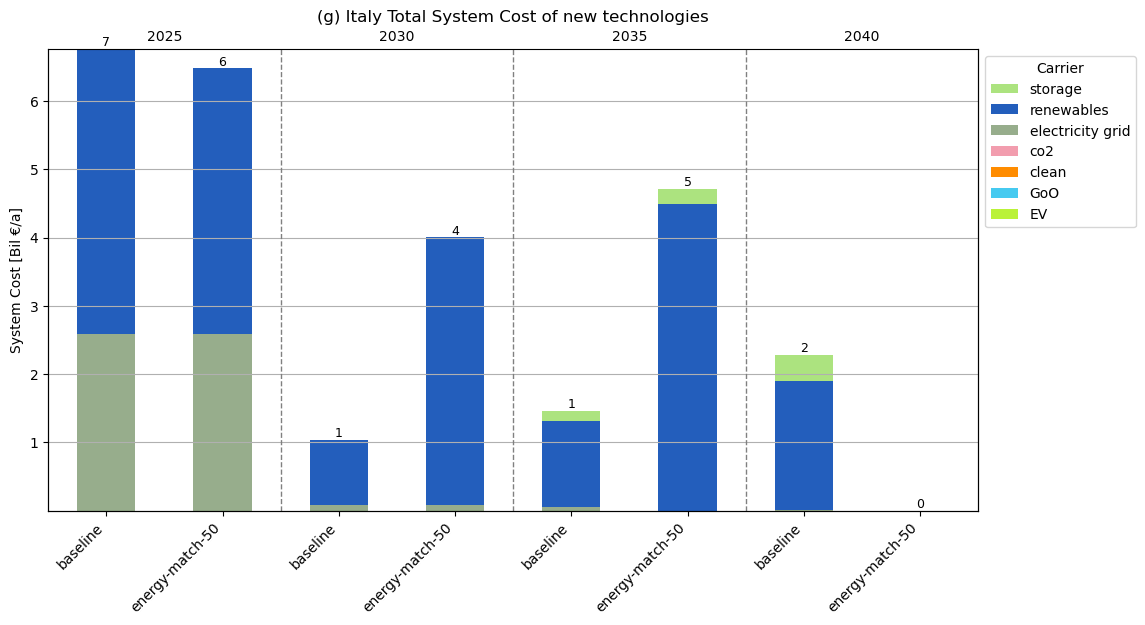

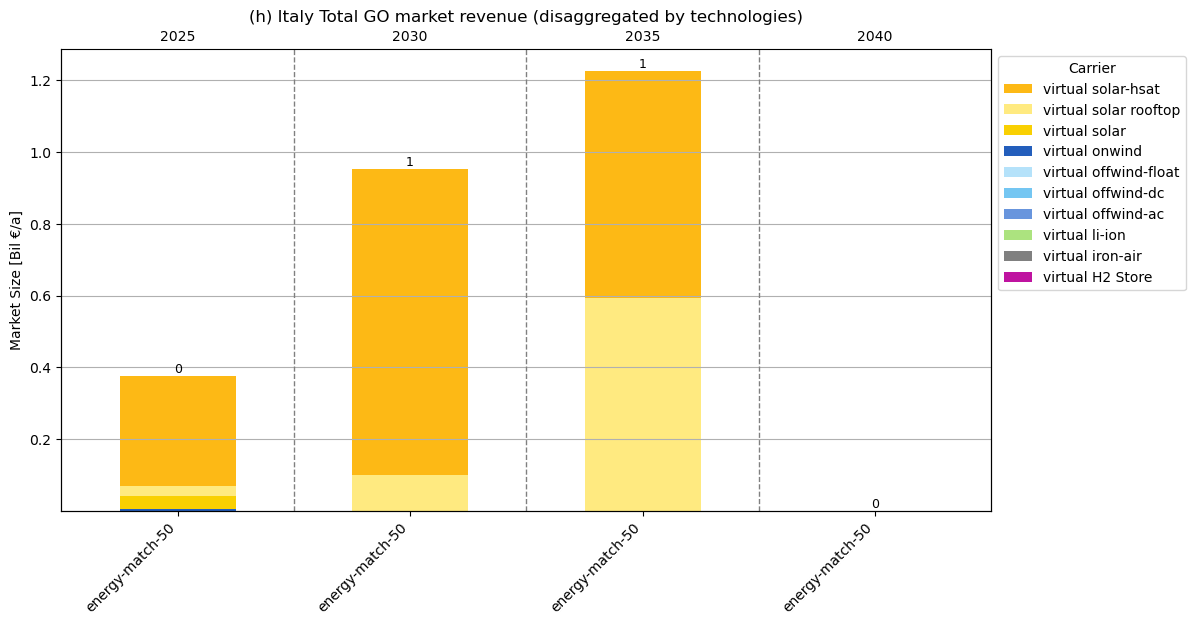

In [54]:
df, colors = get_stats_all(df_networks["network"], "energy_balance", groupby=["carrier","bus_carrier","country1"])
df["color"] = colors
countries = df.index.get_level_values("country1").unique()
countries = ["IT"] #test
for cc in sorted(countries):

    cc_name = country_converter.CountryConverter().convert(cc, to="short_name")

    # (a) Energy mix - Total
    df = df[
        df.index.get_level_values("bus_carrier").isin(["AC",
                                                    "low voltage",
                                                    ])
        & ~df.index.get_level_values("carrier").isin(["AC",
                                                    "DC",
                                                    "electricity",
                                                    "low voltage",
                                                    "electricity distribution grid",
                                                    "BEV charger",
                                                    "home battery charger",
                                                    "home battery discharger",
                                                    ])
        & df.index.get_level_values("country1").isin([cc])
    ]

    df = df.groupby("carrier").apply(sum_except_color)
    df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e6

    ax = plot_bar(df, colors, ylabel="Energy Balance [TWh/a]", title=f"(a) {cc_name} Energy Mixes")

    # (b) Energy mix - GO Market
    df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
    df, colors = get_stats_all(df_GoO["GoO"], "energy_balance", groupby=["carrier", "country1"])
    df["color"] = colors
    df = df[(df.index.get_level_values("carrier") != "GoO")
             & df.index.get_level_values("country1").isin([cc])
            ].groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e6

    ax = plot_bar(df, colors, ylabel="Virtual Generation [GoO TWh/a]", title=f"(b) {cc_name} GO Market Energy Mixes")

    # (c) Capacity mix - Total
    df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier","bus_carrier", "country1"])
    df["color"] = colors

    df = df[
        ~df.index.get_level_values("bus_carrier").isin(["GoO","co2","co2 stored"])
        & ~df.index.get_level_values("carrier").isin(["AC","DC","electricity distribution grid","low voltage"] + list(grouping_storage.keys()))
        & ~df.index.get_level_values("component").isin(["Store","StorageUnit"])
        & df.index.get_level_values("country1").isin([cc])
    ]

    df = df.loc[~df.index.isin([("Generator","coal","coal"),("Generator","gas","gas")])]
    df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e3

    ax = plot_bar(df, colors, ylabel="Capacity [GW]", title=f"(c) {cc_name} Capacity Mixes")

    # (d) Capacity mix - New
    df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier","bus_carrier","build_year", "country1"])

    for c in df.columns:
        scenario_year = int(c[0])
        df.loc[df.index.get_level_values("build_year") != scenario_year,c] = 0

    df["color"] = colors

    df = df[
        ~df.index.get_level_values("bus_carrier").isin(["GoO","co2","co2 stored"])
        & ~df.index.get_level_values("carrier").isin(["AC","DC","electricity distribution grid","low voltage"] + list(grouping_storage.keys()))
        & ~df.index.get_level_values("component").isin(["Store","StorageUnit"])
        & df.index.get_level_values("country1").isin([cc])
    ]

    df = df.loc[~df.index.isin([("Generator","coal","coal"),("Generator","gas","gas")])]
    df = df.rename(index=grouping_storage).groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e3

    ax = plot_bar(df, colors, ylabel="Capacity [GW]", title=f"(d) {cc_name} Capacity Mixes of new technologies")

    # (e) Storage - GO Market - Stores
    df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier", "country1"])
    df["color"] = colors

    df = df[
        df.index.get_level_values("component").isin(["Store"])
        & df.index.get_level_values("carrier").isin(list(grouping_storage.keys()))
        & ~df.index.get_level_values("carrier").isin(['EV battery','home battery'])
        & df.index.get_level_values("country1").isin([cc])
    ]

    df = df.groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e3

    ax = plot_bar(df, colors, ylabel="Storage Capacity [GWh]", title=f"(e) {cc_name} Participating Storage Energy Capacity")

    # (e) Storage - GO Market - Links
    df, colors = get_stats_all(df_networks["network"], "optimal_capacity", groupby=["carrier", "country1"])
    df["color"] = colors

    df = df[
        df.index.get_level_values("component").isin(["Link"])
        & df.index.get_level_values("carrier").isin(list(grouping_storage.keys()))
        & ~df.index.get_level_values("carrier").isin(['BEV charger','li-ion discharger','iron-air discharger','home battery charger','home battery discharger'])
        & df.index.get_level_values("country1").isin([cc])
    ]

    df = df.groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e3

    ax = plot_bar(df, colors, ylabel="Power Capacity [GW]", title=f"(e) {cc_name} Participating Storage Power Capacity")

    # (f) System Cost - Total
    df, _ = get_stats_all(df_networks["network"], "system_cost", groupby=["carrier","country1"])
    df = df[df.index.get_level_values("country1").isin([cc])]
    df = df.rename(index=rename_map).groupby("carrier").sum()
    df = df / 1e9 # to Billion

    colors = [category_colors[i] for i in df.index]

    ax = plot_bar(df, colors, ylabel="System Cost [Bil €/a]", title=f"(f) {cc_name} Total System Cost")

    # (g) System Cost - New
    df, _ = get_stats_all(df_networks["network"], "system_cost", groupby=["carrier","build_year", "country1"])
    df = df[df.index.get_level_values("country1").isin([cc])]

    for c in df.columns:
        scenario_year = int(c[0])
        df.loc[df.index.get_level_values("build_year") != scenario_year,c] = 0

    df = df.rename(index=rename_map).groupby("carrier").sum()
    df = df / 1e9 # to Billion

    colors = [category_colors[i] for i in df.index]

    ax = plot_bar(df, colors, ylabel="System Cost [Bil €/a]", title=f"(g) {cc_name} Total System Cost of new technologies")

    # (h) GO Market Revenue
    df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
    df, colors = get_stats_all(df_GoO["GoO"], "revenue", groupby=["carrier","country1"])
    df["color"] = colors
    df = df[(df.index.get_level_values("carrier") != "GoO")
            & (df.index.get_level_values("country1").isin([cc]))
            ].groupby("carrier").apply(sum_except_color)

    colors = df["color"]
    df = df.drop("color", axis=1)
    df = df / 1e9 # to Billion

    ax = plot_bar(df, colors, ylabel="Market Size [Bil €/a]", title=f"(h) {cc_name} Total GO market revenue (disaggregated by technologies)")